In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2


In [3]:
# current policy
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# current state value
stateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# all possible states
states = []

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# axes for printing use
AxisXPrint = []
AxisYPrint = []
for i in range(0, MAX_CARS + 1):
    for j in range(0, MAX_CARS + 1):
        AxisXPrint.append(i)
        AxisYPrint.append(j)
        states.append([i, j])


# plot a policy/state value matrix
figureIndex = 0
def prettyPrint(data, labels):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    ax = fig.add_subplot(111, projection='3d')
    AxisZ = []
    for i, j in states:
        AxisZ.append(data[i, j])
    ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UP_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poissonBackup = dict()
def poisson(n, lam):
    global poissonBackup
    key = n * 10 + lam
    if key not in poissonBackup.keys():
        poissonBackup[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poissonBackup[key]

# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
def expectedReturn(state, action, stateValue):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # go through all possible rental requests
    for rentalRequestFirstLoc in range(0, POISSON_UP_BOUND):
        for rentalRequestSecondLoc in range(0, POISSON_UP_BOUND):
            # moving cars
            numOfCarsFirstLoc = int(min(state[0] - action, MAX_CARS))
            numOfCarsSecondLoc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            realRentalFirstLoc = min(numOfCarsFirstLoc, rentalRequestFirstLoc)
            realRentalSecondLoc = min(numOfCarsSecondLoc, rentalRequestSecondLoc)

            # get credits for renting
            reward = (realRentalFirstLoc + realRentalSecondLoc) * RENTAL_CREDIT
            numOfCarsFirstLoc -= realRentalFirstLoc
            numOfCarsSecondLoc -= realRentalSecondLoc

            # probability for current combination of rental requests
            prob = poisson(rentalRequestFirstLoc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rentalRequestSecondLoc, RENTAL_REQUEST_SECOND_LOC)

            # if set True, model is simplified such that the # of cars returned in daytime becomes constant
            # rather than a random value from poisson distribution, which will reduce calculation time
            # and leave the optimal policy/value state matrix almost the same
            constantReturnedCars = True
            if constantReturnedCars:
                # get returned cars, those cars can be used for renting tomorrow
                returnedCarsFirstLoc = RETURNS_FIRST_LOC
                returnedCarsSecondLoc = RETURNS_SECOND_LOC
                numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
                numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
            else:
                numOfCarsFirstLoc_ = numOfCarsFirstLoc
                numOfCarsSecondLoc_ = numOfCarsSecondLoc
                prob_ = prob
                for returnedCarsFirstLoc in range(0, POISSON_UP_BOUND):
                    for returnedCarsSecondLoc in range(0, POISSON_UP_BOUND):
                        numOfCarsFirstLoc = numOfCarsFirstLoc_
                        numOfCarsSecondLoc = numOfCarsSecondLoc_
                        prob = prob_
                        numOfCarsFirstLoc = min(numOfCarsFirstLoc + returnedCarsFirstLoc, MAX_CARS)
                        numOfCarsSecondLoc = min(numOfCarsSecondLoc + returnedCarsSecondLoc, MAX_CARS)
                        prob = poisson(returnedCarsFirstLoc, RETURNS_FIRST_LOC) * \
                               poisson(returnedCarsSecondLoc, RETURNS_SECOND_LOC) * prob
                        returns += prob * (reward + DISCOUNT * stateValue[numOfCarsFirstLoc, numOfCarsSecondLoc])
    return returns


newStateValue = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
improvePolicy = False
policyImprovementInd = 0


Policy improvement 0
Policy for 332 states changed
Policy improvement 1
Policy for 286 states changed
Policy improvement 2
Policy for 83 states changed
Policy improvement 3
Policy for 19 states changed
Policy improvement 4
Policy for 0 states changed


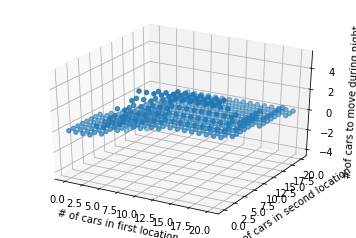

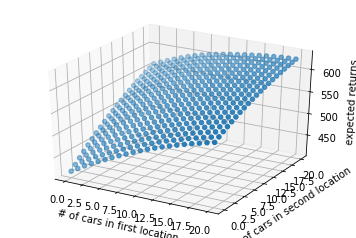

In [4]:
while True:
    if improvePolicy == True:
        # start policy improvement
        print('Policy improvement', policyImprovementInd)
        policyImprovementInd += 1
        newPolicy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
        for i, j in states:
            actionReturns = []
            # go through all actions and select the best one
            for action in actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    actionReturns.append(expectedReturn([i, j], action, stateValue))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i, j] = actions[bestAction]

        # if policy is stable
        policyChanges = np.sum(newPolicy != policy)
        print('Policy for', policyChanges, 'states changed')
        if policyChanges == 0:
            policy = newPolicy
            break
        policy = newPolicy
        improvePolicy = False

    # start policy evaluation
    for i, j in states:
        newStateValue[i, j] = expectedReturn([i, j], policy[i, j], stateValue)
    if np.sum(np.abs(newStateValue - stateValue)) < 1e-4:
        stateValue[:] = newStateValue
        improvePolicy = True
        continue
    stateValue[:] = newStateValue

prettyPrint(policy, ['# of cars in first location', '# of cars in second location', '# of cars to move during night'])
prettyPrint(stateValue, ['# of cars in first location', '# of cars in second location', 'expected returns'])
plt.show()